### 1-K-means with synthetic datasets
The Synthetic dataset is data generated by your own.

**Import libraries**

In [3]:
%matplotlib notebook

import tensorflow as tf
import numpy as np
import time

import matplotlib
import matplotlib.pyplot as plt

from sklearn.datasets.samples_generator import make_blobs
from sklearn.datasets.samples_generator import make_circles

**Definig Constants**

In [4]:
# Defning the number of clusters, in function of DataType
N=200 #n_samples
DATA_TYPE = 'blobs'

if (DATA_TYPE == 'circle'):
    K=2
else:
    K=4
    
# Maximum number of iterations, if the conditions are not met
MAX_ITERS = 1000

start = time.time()

**Generating the dataset** 

In [8]:
centers = [(-2, -2), (-2, 1.5), (1.5, -2), (2, 1.5)]

if (DATA_TYPE == 'circle'):
    data, features = make_circles(n_samples=N, 
                                  shuffle=True,
                                  noise= 0.01, 
#https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html                                  factor=0.4)
else:
    data, features = make_blobs(n_samples=N,
                                centers=centers, 
                                n_features = 2, 
                                cluster_std=0.8, 
                                shuffle=False, 
                                random_state=42)

**Ploting only the centers of the data generated**

<IPython.core.display.Javascript object>


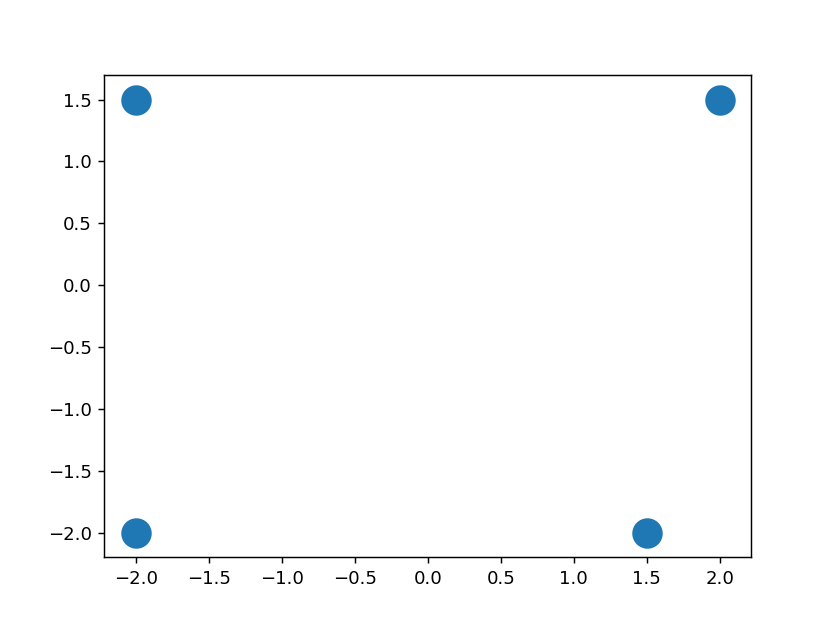

[]

In [25]:
fig, ax = plt.subplots()
ax.scatter(np.asarray(centers).transpose()[0],
           np.asarray(centers).transpose()[1], 
           marker = 'o', s = 250)
plt.plot()

<IPython.core.display.Javascript object>


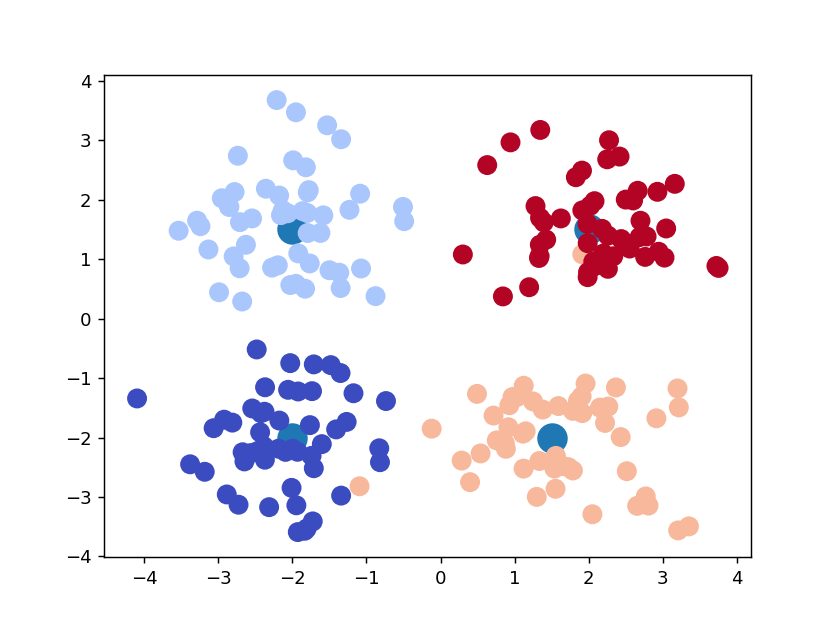

In [10]:
fig, ax = plt.subplots()
if (DATA_TYPE == 'blobs'):
    ax.scatter(np.asarray(centers).transpose()[0], 
               np.asarray(centers).transpose()[1], 
               marker = 'o', 
               s = 250)
    ax.scatter(data.transpose()[0], 
               data.transpose()[1], 
               marker = 'o', 
               s = 100, 
               c = features, 
               cmap=plt.cm.coolwarm )
    plt.plot()

**Model Architecture**
- the points variable contains the 2D coordinates of the dataset points
- the centroids variable will contain the coordinates of the center points of the groups
- the cluster_assignments variable contains the centroid index for each data element.

For example, 

    cluster_assignments[2] = 1  
    
indicates that the data[2] data point pertains to the cluster with the center, centroid 1. The location of centroid 1 is located in centroids[1].

In [18]:
points=tf.Variable(data)
cluster_assignments = tf.Variable(tf.zeros([N], dtype=tf.int64))

centroids = tf.Variable(tf.slice(points.initialized_value(), [0,0], [K,2]))

sess = tf.Session()
sess.run(tf.initialize_all_variables())

sess.run(centroids)

array([[-1.60262868, -2.11061144],
       [-1.48184917, -0.78157611],
       [-2.1873227 , -2.18730957],
       [-0.73662975, -1.38605222]])

**Loss function description and optimizer loop**

Then we will do 
- _N_ copies of all centroids
- _K_ copies of each point
- _N_ x _K_ copies of every point 

so we can calculate the distances between each point and every centroid, for each dimension.

Then we perform the sum for all dimensions and get the index of the lowest sum (this will be
the index of the centroid or cluster assigned for each point).



In [28]:
rep_centroids = tf.reshape(tf.tile(centroids, [N, 1]), [N, K, 2])
rep_points = tf.reshape(tf.tile(points, [1, K]), [N, K, 2])
sum_squares = tf.reduce_sum(tf.square(rep_points - rep_centroids), 
reduction_indices=2)

best_centroids = tf.argmin(sum_squares, 1)  #get the index of the lowest sum

**Stop Condition**

In [30]:
did_assignments_change = tf.reduce_any(tf.not_equal(best_centroids,cluster_assignments))

**Update the centroids**

Centroids will also be updated with a bucket_mean function

In [33]:
def bucket_mean(data, bucket_ids, num_buckets):
    total = tf.unsorted_segment_sum(data, bucket_ids, num_buckets)
    count = tf.unsorted_segment_sum(tf.ones_like(data), bucket_ids, num_buckets)
    return total / count

means = bucket_mean(points, best_centroids, K)

Here, we use control_dependencies to calculate whether we need to update the centroids:

In [34]:
with tf.control_dependencies([did_assignments_change]):
    do_updates = tf.group(centroids.assign(means),
                          cluster_assignments.assign(best_centroids))

In [35]:
changed = True
iters = 0

<IPython.core.display.Javascript object>


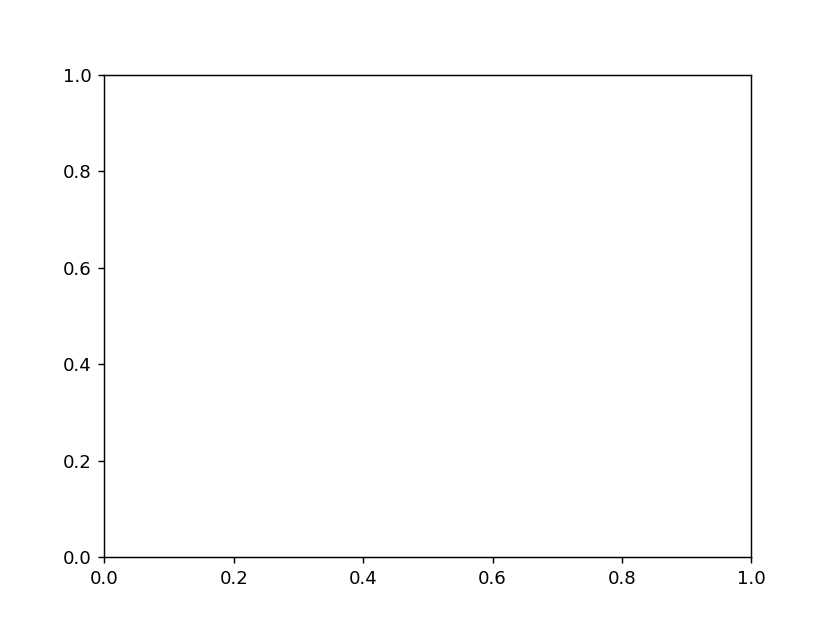

<IPython.core.display.Javascript object>


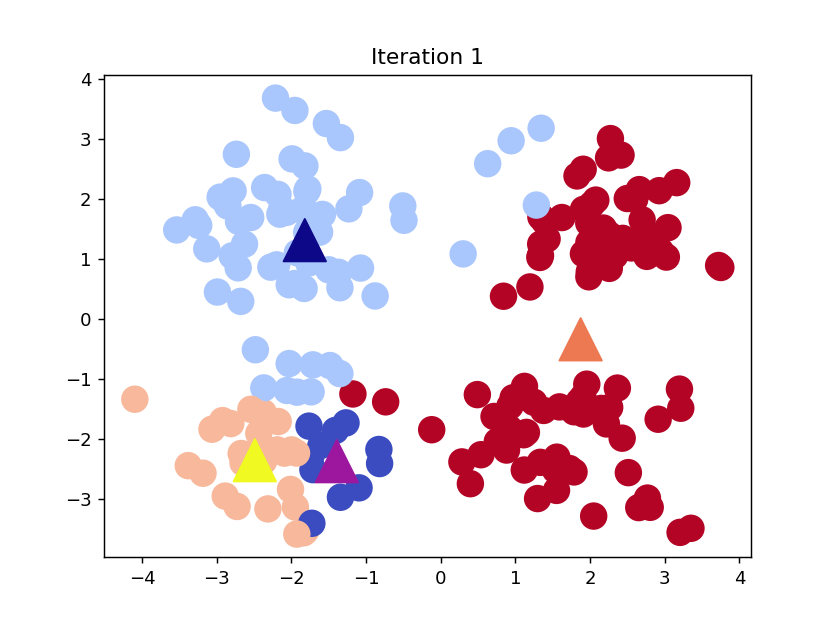

<IPython.core.display.Javascript object>


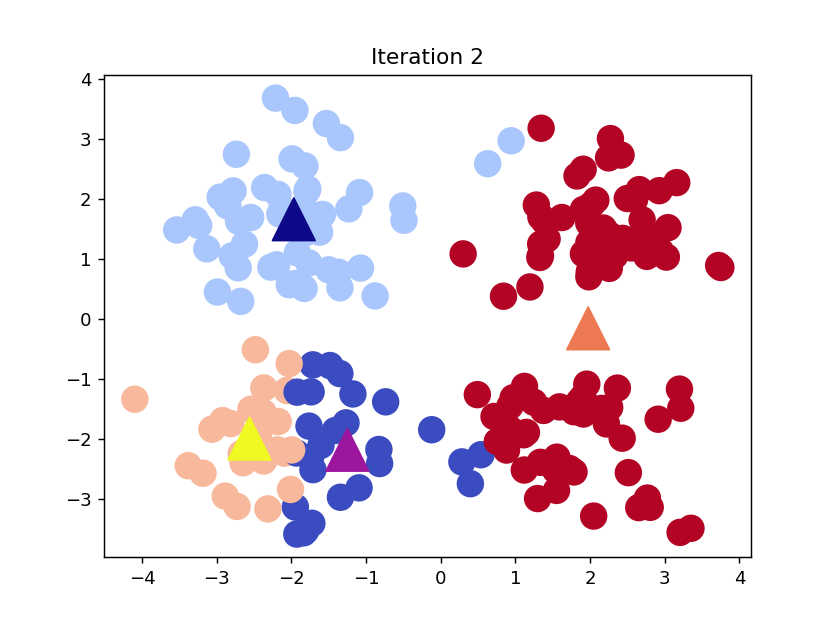

<IPython.core.display.Javascript object>


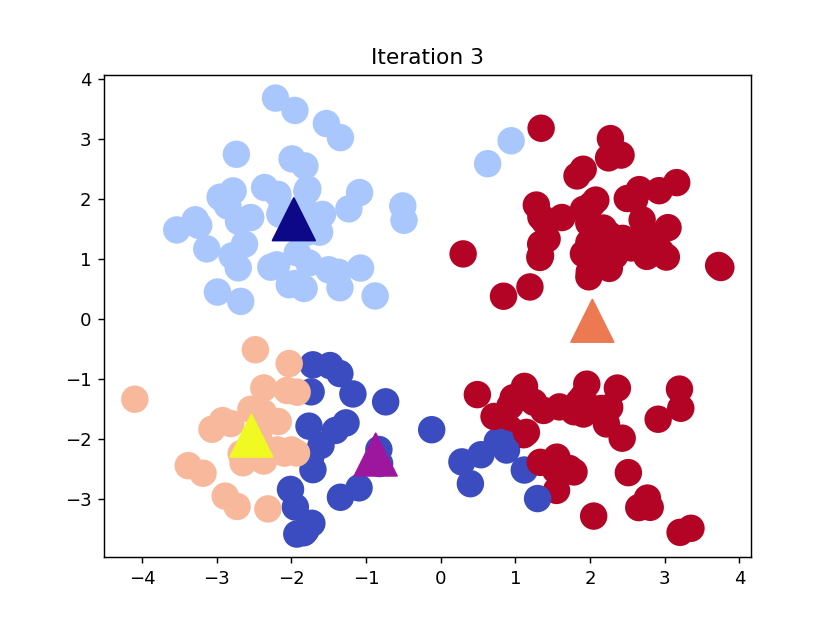

<IPython.core.display.Javascript object>


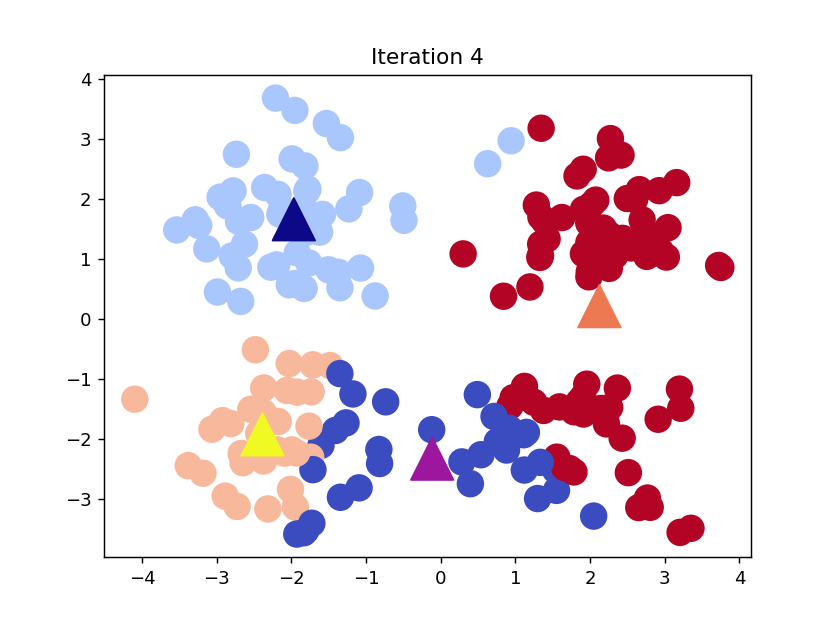

<IPython.core.display.Javascript object>


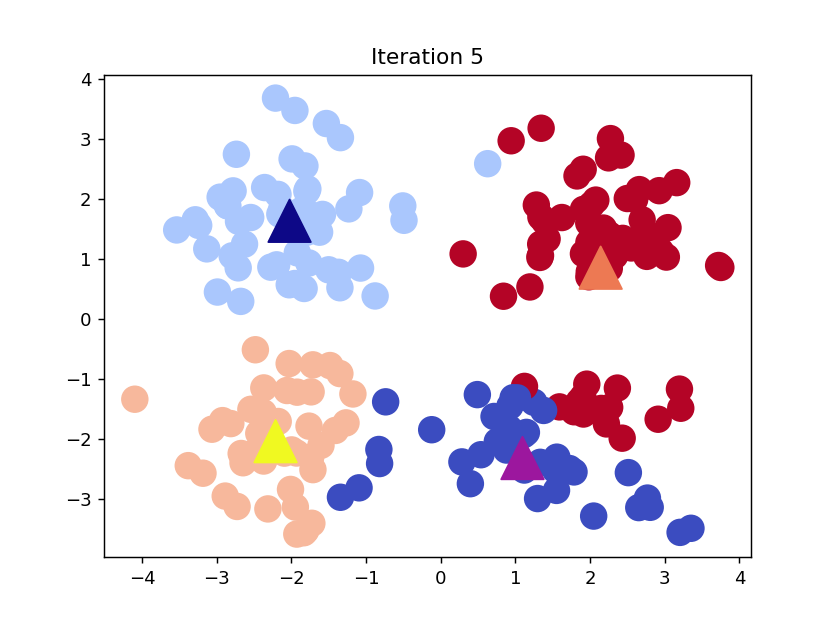

<IPython.core.display.Javascript object>


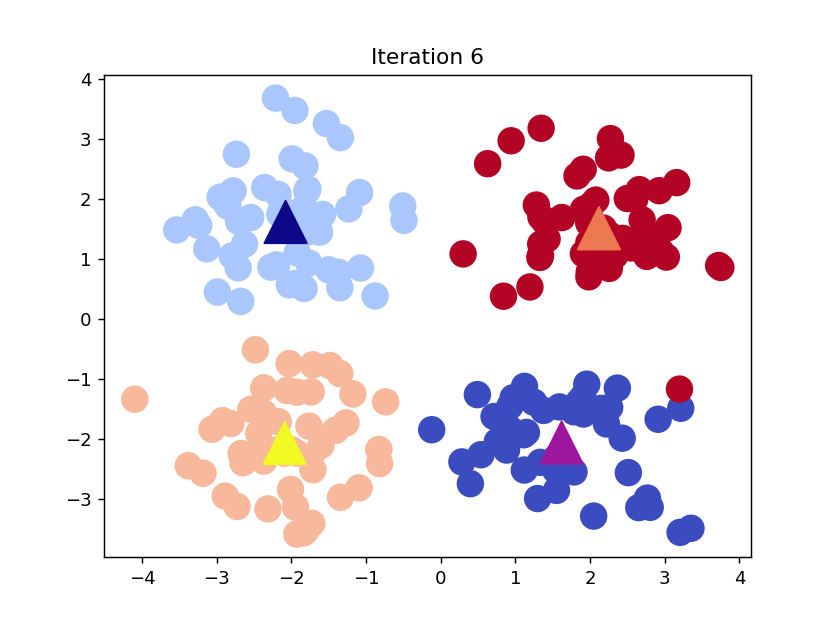

<IPython.core.display.Javascript object>


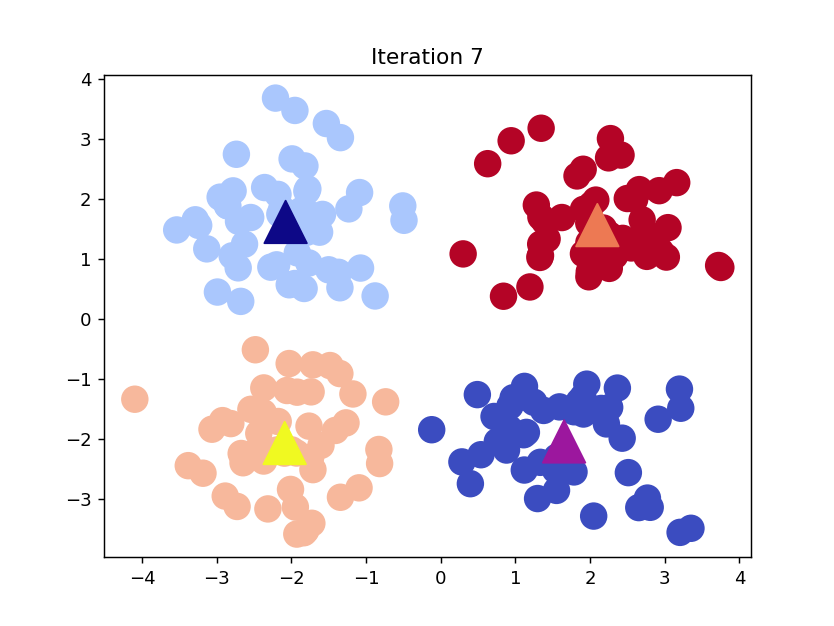

<IPython.core.display.Javascript object>


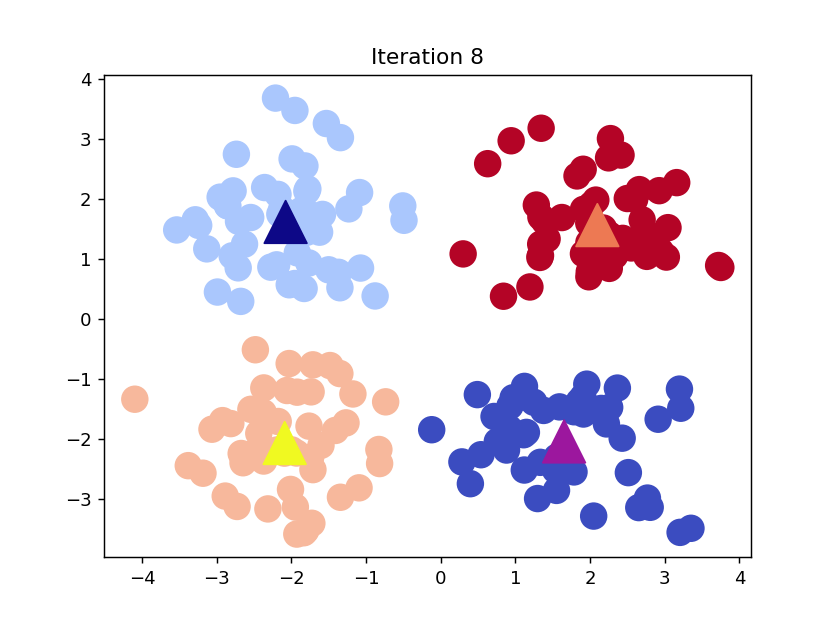

In [36]:
fig, ax = plt.subplots()
if (DATA_TYPE == 'blobs'):
    colourindexes=[2,1,4,3]
else:
    colourindexes=[2,1]
while changed and iters < MAX_ITERS:
    fig, ax = plt.subplots()
    
    iters += 1
    
    [changed, _] = sess.run([did_assignments_change, do_updates])
    
    [centers, assignments] = sess.run([centroids, cluster_assignments])
    
    ax.scatter(sess.run(points).transpose()[0], 
               sess.run(points).transpose()[1], 
               marker = 'o', s = 200, 
               c = assignments, cmap=plt.cm.coolwarm )
    ax.scatter(centers[:,0],centers[:,1], 
               marker = '^', s = 550, 
               c = colourindexes, cmap=plt.cm.plasma)
    
    ax.set_title('Iteration ' + str(iters))
    plt.savefig("kmeans" + str(iters) +".png")